# Analyse ocean heat budget

In [1]:
# if this line is not separated from the line below this cell has to be executed twice
# Jupyter Notebook with widget matplotlib plots
%matplotlib notebook
# Jupyter Lab with widget matplotlib plots
#%matplotlib widget 
# with Jupyter and Jupyter Lab but without widget matplotlib plots
#%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pyicon as pyic  
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
import numpy as np
from netCDF4 import Dataset
import cartopy.crs as ccrs
import seawater as sw
import xarray as xr
import matplotlib.pyplot as plt
import glob

-----calc
sys glob os
numpy
netcdf
Done modules calc.
-----calc_xr
sys glob os
numpy
netcdf
xarray
Done modules calc.
-----tb
sys
json
numpy
scipy
netcdf datetime
matplotlib
mybreak
pnadas
xarray
done xarray
-----IconData
-----plotting
-----view
-----calc
-----calc_xr
-----tb
-----IconData
-----plotting
-----view
-----quickplots
-----quickplots


In [3]:
run = 'dpp0053'
path_data = f'/work/mh0287/k203123/GIT/icon-aes-dyw3/experiments/{run}/'

fpath_ckdtree = '/mnt/lustre01/work/mh0033/m300602/icon/grids/r2b9_oce_r0004/ckdtree/rectgrids/r2b9_oce_r0004_res0.30_180W-180E_90S-90N.nc'

In [4]:
mfdset_kwargs = dict(combine='nested', concat_dim='time',
                     data_vars='minimal', coords='minimal', compat='override', join='override',
                     parallel=True,
                    )

## Get a cluster

In [5]:
import multiprocessing
from dask_jobqueue import SLURMCluster # Setting up distributed memories via slurm
from dask.utils import format_bytes
from dask.distributed import Client, LocalCluster, progress # Libaray to orchestrate distributed resources

from tempfile import NamedTemporaryFile, TemporaryDirectory # Creating temporary Files/Dirs
from getpass import getuser # Libaray to copy things
from pathlib import Path # Object oriented libary to deal with paths

In [6]:
# Set some user specific variables
account_name = 'bm1102' # Account that is going to be 'charged' fore the computation
queue = 'gpu' # Name of the partition we want to use
job_name = 'PostProc' # Job name that is submitted via sbatch
memory = "100GiB" # Max memory per node that is going to be used - this depends on the partition
cores = 24 # Max number of cores per task that are reserved - also partition dependend
walltime = '8:00:00' # Walltime - also partition dependent

In [7]:
scratch_dir = Path('/scratch') / getuser()[0] / getuser() # Define the users scratch dir
# Create a temp directory where the output of distributed cluster will be written to, after this notebook
# is closed the temp directory will be closed
dask_tmp_dir = TemporaryDirectory(dir=scratch_dir, prefix=job_name)
cluster = SLURMCluster(memory=memory,
                       cores=cores,
                       project=account_name,
                       walltime=walltime,
                       queue=queue,
                       name=job_name,
                       scheduler_options={'dashboard_address': ':8787'},
                       local_directory=dask_tmp_dir.name,
                       job_extra=[f'-J {job_name}', 
                                  f'-D {dask_tmp_dir.name}',
                                  f'--begin=now',
                                  f'--output={dask_tmp_dir.name}/LOG_cluster.%j.o',
                                  f'--output={dask_tmp_dir.name}/LOG_cluster.%j.o'
                                 ],
                       interface='ib0')

In [8]:
print(cluster.job_script())

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p gpu
#SBATCH -A bm1102
#SBATCH -n 1
#SBATCH --cpus-per-task=24
#SBATCH --mem=100G
#SBATCH -t 8:00:00
#SBATCH -J PostProc
#SBATCH -D /scratch/m/m300602/PostProcifek097s
#SBATCH --begin=now
#SBATCH --output=/scratch/m/m300602/PostProcifek097s/LOG_cluster.%j.o
#SBATCH --output=/scratch/m/m300602/PostProcifek097s/LOG_cluster.%j.o

/work/mh0033/m300602/miniconda3/envs/pyicon_py39/bin/python -m distributed.cli.dask_worker tcp://10.50.34.181:34641 --nthreads 4 --nprocs 6 --memory-limit 16.67GiB --name dummy-name --nanny --death-timeout 60 --local-directory /scratch/m/m300602/PostProcifek097s --interface ib0 --protocol tcp://



In [9]:
cluster.scale(jobs=1)
cluster

In [12]:
! squeue -u $USER

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          33251613       gpu PostProc  m300602  R       0:04      1 mg101
          33250934       gpu     bash  m300602  R      49:10      1 mg100


In [11]:
client = Client(cluster)
client

<Client: 'tcp://10.50.34.181:34641' processes=0 threads=0, memory=0 B>

## Prepare data

In [13]:
ds_ckdt = xr.open_dataset(fpath_ckdtree)
ds_ckdt

<xarray.Dataset>
Dimensions:     (lat: 600, lon: 1200)
Coordinates:
  * lat         (lat) float64 -90.0 -89.7 -89.4 -89.1 ... 88.8 89.1 89.4 89.7
  * lon         (lon) float64 -180.0 -179.7 -179.4 -179.1 ... 179.1 179.4 179.7
Data variables:
    dckdtree_c  (lat, lon) float64 ...
    ickdtree_c  (lat, lon) int64 ...
    dckdtree_e  (lat, lon) float64 ...
    ickdtree_e  (lat, lon) int64 ...
    dckdtree_v  (lat, lon) float64 ...
    ickdtree_v  (lat, lon) int64 ...

In [14]:
!ls /mnt/lustre01/work/mh0033/m300602/icon/grids/r2b9_oce_r0004/

ckdtree
exp.ocean_era51h_zstar_r2b9_21249-DXB_fx_20181001T000200Z.nc
pwd
r2b9_oce_r0004_L128_fx.nc
r2b9_oce_r0004_L128_zstar_fx.nc
r2b9_oce_r0004_tgrid.nc


In [15]:
fpath_fx = '/mnt/lustre01/work/mh0033/m300602/icon/grids/r2b9_oce_r0004/r2b9_oce_r0004_L128_fx.nc'
ds_fx = xr.open_mfdataset(fpath_fx, chunks=dict(depth=1, depth_2=1))

In [16]:
fpath_tgrid = '/mnt/lustre01/work/mh0033/m300602/icon/grids/r2b9_oce_r0004/r2b9_oce_r0004_tgrid.nc'
ds_tg = xr.open_dataset(fpath_tgrid)
clon = ds_tg.clon*180./np.pi
clat = ds_tg.clat*180./np.pi
clon = clon.data
clat = clat.data

In [17]:
lon0 = np.array([-140, -30, 0, -180, -140])
lat0 = np.array([-30, 26, -60, -15, 0])

# ilon = np.argmin((lon-lon0)**2)
# ilat = np.argmin((lat-lat0)**2)
ic = np.argmin( (clon-lon0[:,np.newaxis])**2 + (clat-lat0[:,np.newaxis])**2, axis=1)
clon[ic], clat[ic]

(array([-1.40010938e+02, -3.00006368e+01,  1.82134969e-02, -1.79970226e+02,
        -1.40007968e+02]),
 array([-3.00000956e+01,  2.59849414e+01, -5.99867767e+01, -1.50075330e+01,
        -2.10516039e-02]))

### Open ICON data

In [18]:
%%time
flist = glob.glob(f'{path_data}{run}_oce_3du200m_PT3H_202001*.nc')
flist.sort()
flist = flist[:10]

ds = xr.open_mfdataset(flist, **mfdset_kwargs, chunks=dict(time=1, depth=1, depth_2=1))
# ds = xr.open_mfdataset(flist, **mfdset_kwargs)

CPU times: user 452 ms, sys: 58 ms, total: 510 ms
Wall time: 2.62 s


In [19]:
ds

<xarray.Dataset>
Dimensions:        (depth: 40, depth_2: 40, ncells: 14886338, ncells_2: 22375924, time: 79)
Coordinates:
  * depth          (depth) float64 1.0 3.05 5.2 7.45 ... 177.1 187.1 197.6 208.5
  * depth_2        (depth_2) float64 0.0 2.0 4.1 6.3 ... 172.2 182.0 192.2 202.9
  * time           (time) datetime64[ns] 2020-01-20T03:00:00 ... 2020-01-29T2...
Dimensions without coordinates: ncells, ncells_2
Data variables:
    to             (time, depth, ncells) float32 dask.array<chunksize=(1, 1, 14886338), meta=np.ndarray>
    so             (time, depth, ncells) float32 dask.array<chunksize=(1, 1, 14886338), meta=np.ndarray>
    u              (time, depth, ncells) float32 dask.array<chunksize=(1, 1, 14886338), meta=np.ndarray>
    v              (time, depth, ncells) float32 dask.array<chunksize=(1, 1, 14886338), meta=np.ndarray>
    w              (time, depth_2, ncells) float32 dask.array<chunksize=(1, 1, 14886338), meta=np.ndarray>
    A_tracer_v_to  (time, depth_2, ncells) float32 dask.array<chunksize=(1, 1, 14886338), meta=np.ndarray>
    A_veloc_v      (time, depth_2, ncells_2) float32 dask.array<chunksize=(1, 1, 22375924), meta=np.ndarray>
    tke            (time, depth_2, ncells) float32 dask.array<chunksize=(1, 1, 14886338), meta=np.ndarray>
Attributes:
    CDI:                  Climate Data Interface version 1.8.3rc (http://mpim...
    Conventions:          CF-1.6
    grid_file_uri:        http://icon-downloads.mpimet.mpg.de/grids/public/mp...
    number_of_grid_used:  16
    uuidOfHGrid:          375cb0cc-637e-11e8-9d6f-8f41a9b9ff4b
    institution:          Max Planck Institute for Meteorology/Deutscher Wett...
    title:                ICON simulation
    source:               git@gitlab.dkrz.de:icon/icon-aes.git@540c82944f5dd8...
    history:              /work/mh0287/k203123/GIT/icon-aes-dyw3/bin/icon at ...
    references:           see MPIM/DWD publications
    comment:              Sapphire Dyamond (k203123) on m21156 (Linux 2.6.32-...

In [20]:
flist = glob.glob(f'{path_data}{run}_oce_2dhf_PT3H_202001*.nc')
flist.sort()
flist = flist[:10]

ds_2d = xr.open_mfdataset(flist, **mfdset_kwargs, chunks=dict(time=0))

In [21]:
ds_2d

<xarray.Dataset>
Dimensions:                              (lev: 1, ncells: 14886338, time: 79)
Coordinates:
  * lev                                  (lev) float64 0.0
  * time                                 (time) datetime64[ns] 2020-01-20T03:...
Dimensions without coordinates: ncells
Data variables: (12/25)
    zos                                  (time, ncells) float32 dask.array<chunksize=(7, 14886338), meta=np.ndarray>
    mlotst                               (time, ncells) float32 dask.array<chunksize=(7, 14886338), meta=np.ndarray>
    stretch_c                            (time, ncells) float32 dask.array<chunksize=(7, 14886338), meta=np.ndarray>
    Qtop                                 (time, lev, ncells) float32 dask.array<chunksize=(7, 1, 14886338), meta=np.ndarray>
    Qbot                                 (time, lev, ncells) float32 dask.array<chunksize=(7, 1, 14886338), meta=np.ndarray>
    atmos_fluxes_stress_x                (time, ncells) float32 dask.array<chunksize=(7, 14886338), meta=np.ndarray>
    ...                                   ...
    Wind_Speed_10m                       (time, ncells) float32 dask.array<chunksize=(7, 14886338), meta=np.ndarray>
    hi                                   (time, lev, ncells) float32 dask.array<chunksize=(7, 1, 14886338), meta=np.ndarray>
    hs                                   (time, lev, ncells) float32 dask.array<chunksize=(7, 1, 14886338), meta=np.ndarray>
    conc                                 (time, lev, ncells) float32 dask.array<chunksize=(7, 1, 14886338), meta=np.ndarray>
    ice_u                                (time, ncells) float32 dask.array<chunksize=(7, 14886338), meta=np.ndarray>
    ice_v                                (time, ncells) float32 dask.array<chunksize=(7, 14886338), meta=np.ndarray>
Attributes:
    CDI:                  Climate Data Interface version 1.8.3rc (http://mpim...
    Conventions:          CF-1.6
    number_of_grid_used:  16
    grid_file_uri:        http://icon-downloads.mpimet.mpg.de/grids/public/mp...
    uuidOfHGrid:          375cb0cc-637e-11e8-9d6f-8f41a9b9ff4b
    institution:          Max Planck Institute for Meteorology/Deutscher Wett...
    title:                ICON simulation
    source:               git@gitlab.dkrz.de:icon/icon-aes.git@540c82944f5dd8...
    history:              /work/mh0287/k203123/GIT/icon-aes-dyw3/bin/icon at ...
    references:           see MPIM/DWD publications
    comment:              Sapphire Dyamond (k203123) on m21156 (Linux 2.6.32-...

## Cut region

In [246]:
lon0 = np.array([-140])
lat0 = np.array([-30])

# ilon = np.argmin((lon-lon0)**2)
# ilat = np.argmin((lat-lat0)**2)
ic0 = np.argmin( (clon-lon0[:,np.newaxis])**2 + (clat-lat0[:,np.newaxis])**2, axis=1)

In [247]:
ic = np.unique(ds_IcD['adjacent_cell_of_edge'][ds_IcD['edge_of_cell'][ic]])

## Select data subset

In [341]:
rho0 = 1025.022
rhoi = 917.0
rhos = 300.0
sal_ref = 35.
sal_ice = 5.
rcpl = 3.1733
cpd = 1004.64
cp = (rcpl + 1.0) * cpd

In [342]:
# it = np.array([0,4,8])
it = np.arange(16)
nz = 30
iz = np.arange(nz)
izi = np.arange(nz+1)

In [343]:
dzt = ds_fx.constantPrismCenters_Zdistance[izi,ic].compute().data
dzw = ds_fx.prism_thick_c[iz,ic].compute().data

In [344]:
%%time
to = ds.to.isel(time=it, depth=iz, ncells=ic).compute()
so = ds.so.isel(time=it, depth=iz, ncells=ic).compute()
# u = ds.u.isel(time=it, depth=iz, ncells=ic).compute()
# v = ds.v.isel(time=it, depth=iz, ncells=ic).compute()
A_tracer_v_to = ds.A_tracer_v_to.isel(time=it, depth_2=izi, ncells=ic).compute()
w = ds.w.isel(time=it, depth_2=izi, ncells=ic).compute()

CPU times: user 25.4 s, sys: 1.79 s, total: 27.2 s
Wall time: 1min 30s


In [345]:
nt = it.size

In [346]:
to_np = to.data
kv_np = A_tracer_v_to.data
wo_np = w.data

## Vertical mixing

In [347]:
flux_to_vdf = np.zeros((nt, nz+1, ic.size))
flux_to_vdf[:,1:-1,:] = -kv_np[:,1:-1,:]*(to_np[:,:-1,:]-to_np[:,1:,:])/dzt[np.newaxis,1:-1,:]
Tt_vdf = np.zeros((nt, nz, ic.size))
Tt_vdf[:,:,:] = (flux_to_vdf[:,:-1,:]-flux_to_vdf[:,1:,:])/dzw

Tt_vdf *= cp*rho0 * dzw

## Vertical advection

In [348]:
flux_to_vad = np.zeros((nt, nz+1, ic.size))
flux_to_vad[:,1:-1,:] = 0.5*(to_np[:,:-1,:]+to_np[:,1:,:])*wo_np[:,1:-1,:]
Tt_vad = np.zeros((nt, nz, ic.size))
Tt_vad[:,:,:] = (flux_to_vad[:,:-1,:]-flux_to_vad[:,1:,:])/dzw
Tt_vad[:,-1,:] = 0.

Tt_vad *= cp*rho0 *dzw

## Horizontal advection

In [265]:
%%time
ds_IcD = pyic.convert_tgrid_data(ds_tg)
ds_IcD = ds_IcD.persist()

CPU times: user 11 s, sys: 10.4 s, total: 21.4 s
Wall time: 20 s


In [266]:
# mask = np.zeros((clon.size), dtype=bool)
# mask[ic] = True
# mask_xr = xr.DataArray(mask, dims=['cell'])

In [267]:
%%time
ds_IcD_sel = ds_IcD.copy()

CPU times: user 0 ns, sys: 62 ms, total: 62 ms
Wall time: 61.7 ms


In [268]:
%%time

numc = ds_IcD_sel.clon.size
nume = ds_IcD_sel.elon.size
numv = ds_IcD_sel.vlon.size

ds_IcD_sel = ds_IcD_sel.isel(cell=ic)
ie = np.unique(ds_IcD_sel['edge_of_cell'].data)
ds_IcD_sel = ds_IcD_sel.isel(edge=ie)
iv = np.unique(ds_IcD_sel['vertex_of_cell'].data)

indc = -1*np.ones(numc, dtype=int)
indc[ic] = np.arange(ic.size, dtype=int)
indc = xr.DataArray(indc, dims=['cell'])

inde = -1*np.ones(nume, dtype=int)
inde[ie] = np.arange(ie.size, dtype=int)
inde = xr.DataArray(inde, dims=['edge'])

indv = -1*np.ones(numv, dtype=int)
indv[iv] = np.arange(iv.size, dtype=int)
indv = xr.DataArray(indv, dims=['vertex'])

svars = ['adjacent_cell_of_edge', 'cells_of_vertex']
for var in svars:
    ds_IcD_sel[var] = indc[ds_IcD_sel[var]]
    
svars = ['edge_of_cell', 'edges_of_vertex']
for var in svars:
    ds_IcD_sel[var] = inde[ds_IcD_sel[var]]
    
svars = ['vertex_of_cell', 'vertices_of_vertex', 'edge_vertices']
for var in svars:
    ds_IcD_sel[var] = indv[ds_IcD_sel[var]]

CPU times: user 751 ms, sys: 1.36 s, total: 2.11 s
Wall time: 1.96 s


In [270]:
# ds_IcD_sel

In [271]:
%%time
div_coeff = pyic.xr_calc_div_coeff(ds_IcD_sel)
div_coeff = div_coeff.persist()

CPU times: user 8 ms, sys: 3 ms, total: 11 ms
Wall time: 8.13 ms


In [272]:
%%time
edge2cell_coeff_cc_t = pyic.xr_calc_edge2cell_coeff_cc_t(ds_IcD_sel)
edge2cell_coeff_cc_t = edge2cell_coeff_cc_t.persist()

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 7.61 ms


In [321]:
uT = (ds.u*ds.to).isel(time=it, depth=iz, ncells=ic)
vT = (ds.v*ds.to).isel(time=it, depth=iz, ncells=ic)

uT = uT.rename({'ncells': 'cell'})
vT = vT.rename({'ncells': 'cell'})

In [322]:
%%time
p_uTvT = pyic.xr_calc_3d_from_2dlocal(ds_IcD_sel, uT, vT)
# p_uTvT = p_uTvT.persist()

CPU times: user 33 ms, sys: 1 ms, total: 34 ms
Wall time: 33.1 ms


In [323]:
%%time
pTp_uTvT = pyic.xr_cell2edges(ds_IcD_sel, p_uTvT, edge2cell_coeff_cc_t=edge2cell_coeff_cc_t)
# pTp_uTvT = pTp_uTvT.persist()

CPU times: user 46 ms, sys: 1 ms, total: 47 ms
Wall time: 46.3 ms


In [324]:
%%time
div_pTp_uTvT = pyic.xr_calc_div(ds_IcD_sel, pTp_uTvT, div_coeff=div_coeff)
div_pTp_uTvT = div_pTp_uTvT.compute()

CPU times: user 35.6 s, sys: 1.89 s, total: 37.5 s
Wall time: 1min 11s


In [357]:
Tt_had = -div_pTp_uTvT#.where(xr.DataArray(ic, dims=['cell'])==ic0, drop=True)

In [358]:
Tt_had = Tt_had.data
Tt_had *= cp*rho0 *dzw

## Time change

In [349]:
dt = 3600.*3.
Tt_ten = np.zeros(to_np.shape)
Tt_ten[1:-1,:,:] = (to_np[2:,:,:] - to_np[:-2,:,:])/(2*dt)
Tt_ten *= cp*rho0 *dzw

## Surface forcing

In [351]:
%%time
atmos_fluxes_HeatFlux_Total = ds_2d.atmos_fluxes_HeatFlux_Total.isel(time=it, ncells=ic).compute()

CPU times: user 227 ms, sys: 79 ms, total: 306 ms
Wall time: 1.73 s


## Plotting

In [352]:
depth = ds.depth[iz].data
depthi = ds.depth_2[izi].data

In [353]:
dzw.shape

(30, 4)

<IPython.core.display.Javascript object>


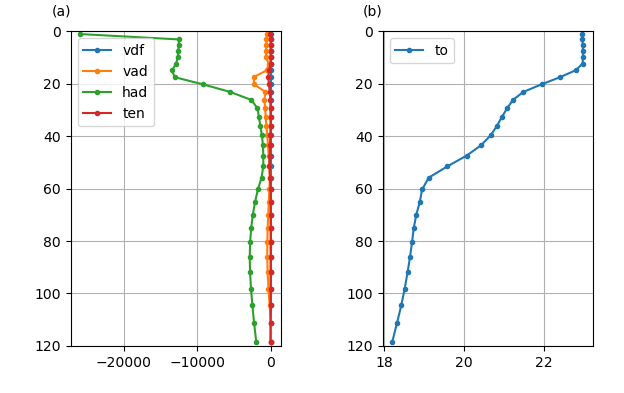

In [359]:
hca, hcb = pyic.arrange_axes(2, 1, asp=1.5, fig_size_fac=2, 
                             sharex=True, sharey=False, plot_cb=False,
                            )
ii=-1
ll = 3
# icc = 0
icc = np.where(ic==ic0)[0][0]

ii+=1; ax=hca[ii]; cax=hcb[ii]
# for ll in range(16):
ax.plot(Tt_vdf[ll, :, icc], depth, label='vdf', marker='.')
ax.plot(Tt_vad[ll, :, icc], depth, label='vad', marker='.')
ax.plot(Tt_had[ll, :, icc], depth, label='had', marker='.')
ax.plot(Tt_ten[ll, :, icc], depth, label='ten', marker='.')
ax.legend()

ii+=1; ax=hca[ii]; cax=hcb[ii]
ax.plot(to[ll, :, icc], depth, label='to', marker='.')
# ax.plot(Tt_vad[ll, :, icc], depth, label='vad', marker='.')
ax.legend()

for ax in hca:
    ax.set_ylim(120,0)
    ax.grid(True)

<IPython.core.display.Javascript object>


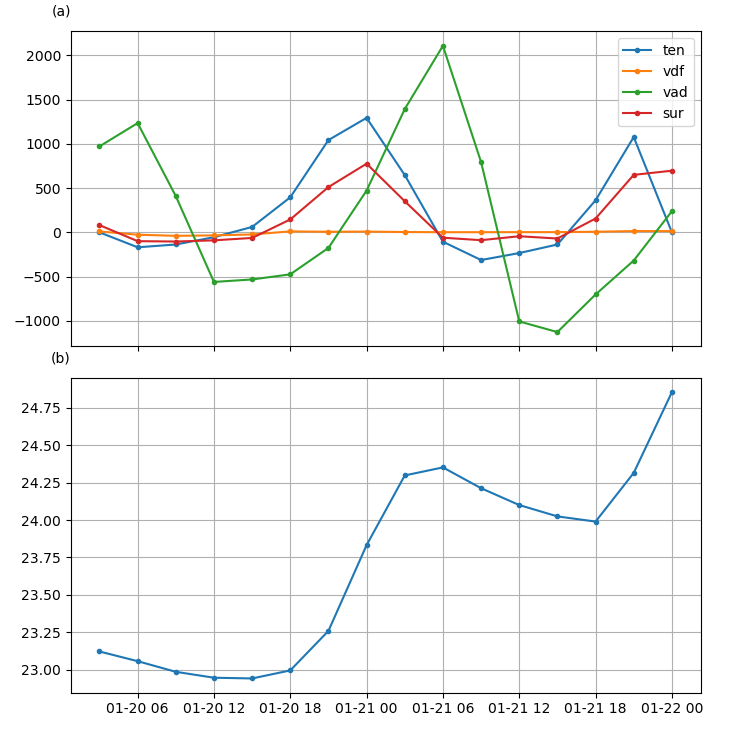

In [361]:
hca, hcb = pyic.arrange_axes(1,2, asp=0.5, fig_size_fac=2, 
                             sharex=True, sharey=False, plot_cb=False,
                            )
ii=-1
ll = 2
icc = np.where(ic==ic0)[0][0]

ii+=1; ax=hca[ii]; cax=hcb[ii]
# for ll in range(16):
ax.plot(ds.time[:16], Tt_ten[:, 0, icc], label='ten', marker='.')
ax.plot(ds.time[:16], Tt_vdf[:, 0, icc], label='vdf', marker='.')
ax.plot(ds.time[:16], Tt_vad[:, 0, icc], label='vad', marker='.')
# ax.plot(ds.time[:16], Tt_had[:, 0, icc], label='had', marker='.')
ax.plot(ds.time[:16], atmos_fluxes_HeatFlux_Total[:,icc], label='sur', marker='.')
# ax.plot(ds.time[:16], Tt_vdf[:, 1, icc], label='vdf_1', marker='.')
# ax.plot(Tt_vad[ll, :, icc], depth, label='vad', marker='.')
ax.legend()

ii+=1; ax=hca[ii]; cax=hcb[ii]
ax.plot(ds.time[:16], to_np[:, 0, icc], label='to', marker='.')
# ax.plot(to[ll, :, icc], depth, label='to', marker='.')
# # ax.plot(Tt_vad[ll, :, icc], depth, label='vad', marker='.')
# ax.legend()

for ax in hca:
#     ax.set_ylim(120,0)
    ax.grid(True)

# Copy-past from different script

In [12]:
%%time
iz = 0
it = 10
toi = pyic.interp_to_rectgrid_xr(ds.to.isel(depth=iz, time=it).compute(), fpath_ckdtree)

CPU times: user 805 ms, sys: 219 ms, total: 1.02 s
Wall time: 1.15 s


In [20]:
lon = toi.lon
lat = toi.lat

<IPython.core.display.Javascript object>


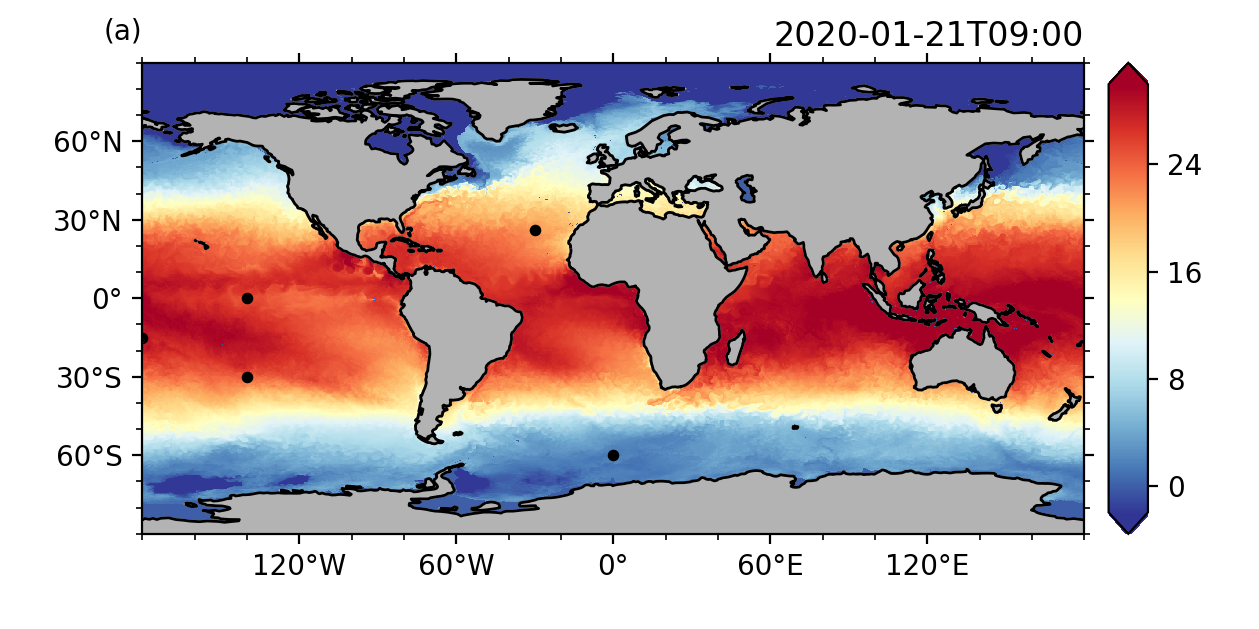

In [21]:
ccrs_proj = ccrs.PlateCarree()

hca, hcb = pyic.arrange_axes(1, 1, asp=0.5, projection=ccrs_proj, fig_size_fac=1.5, 
                             sharex=True, sharey=True, plot_cb=True,
                            )
ii=-1

ii+=1; ax=hca[ii]; cax=hcb[ii]
pyic.shade(lon, lat, toi, ax=ax, cax=cax, clim=[-2, 30])
ax.set_title(str(toi.time.data)[:16], loc='right')

ax.scatter(lon0, lat0, c='k', s=10)

for ax in hca:
    pyic.plot_settings(ax, template='global')

In [22]:
ds = ds[['to', 'so', 'tke', 'u', 'v']]
# ds = ds[['to']]
ds

<xarray.Dataset>
Dimensions:  (depth: 40, depth_2: 40, ncells: 14886338, time: 79)
Coordinates:
  * depth    (depth) float64 1.0 3.05 5.2 7.45 9.8 ... 177.1 187.1 197.6 208.5
  * depth_2  (depth_2) float64 0.0 2.0 4.1 6.3 8.6 ... 172.2 182.0 192.2 202.9
  * time     (time) datetime64[ns] 2020-01-20T03:00:00 ... 2020-01-29T21:00:00
Dimensions without coordinates: ncells
Data variables:
    to       (time, depth, ncells) float32 dask.array<chunksize=(1, 1, 14886338), meta=np.ndarray>
    so       (time, depth, ncells) float32 dask.array<chunksize=(1, 1, 14886338), meta=np.ndarray>
    tke      (time, depth_2, ncells) float32 dask.array<chunksize=(1, 1, 14886338), meta=np.ndarray>
    u        (time, depth, ncells) float32 dask.array<chunksize=(1, 1, 14886338), meta=np.ndarray>
    v        (time, depth, ncells) float32 dask.array<chunksize=(1, 1, 14886338), meta=np.ndarray>
Attributes:
    CDI:                  Climate Data Interface version 1.8.3rc (http://mpim...
    Conventions:          CF-1.6
    grid_file_uri:        http://icon-downloads.mpimet.mpg.de/grids/public/mp...
    number_of_grid_used:  16
    uuidOfHGrid:          375cb0cc-637e-11e8-9d6f-8f41a9b9ff4b
    institution:          Max Planck Institute for Meteorology/Deutscher Wett...
    title:                ICON simulation
    source:               git@gitlab.dkrz.de:icon/icon-aes.git@540c82944f5dd8...
    history:              /work/mh0287/k203123/GIT/icon-aes-dyw3/bin/icon at ...
    references:           see MPIM/DWD publications
    comment:              Sapphire Dyamond (k203123) on m21156 (Linux 2.6.32-...

In [25]:
%%time
# ds_sel = ds.isel(ncells=ic, depth=slice(0,10)).compute()
ds_sel = ds.isel(ncells=ic).compute()

CPU times: user 3min 56s, sys: 12.5 s, total: 4min 8s
Wall time: 12min 2s


In [49]:
# %%time
# to_sel = ds.to.isel(ncells=ic, depth=slice(0,10)).compute()
# so_sel = ds.so.isel(ncells=ic, depth=slice(0,10)).compute()
# tke_sel = ds.tke.isel(ncells=ic, depth_2=slice(0,10)).compute()
# u_sel = ds.u.isel(ncells=ic, depth=slice(0,10)).compute()
# v_sel = ds.v.isel(ncells=ic, depth=slice(0,10)).compute()

In [32]:
pvars = [
    'atmos_fluxes_HeatFlux_Total',
    'atmos_fluxes_HeatFlux_ShortWave',
    'atmos_fluxes_HeatFlux_LongWave',
    'atmos_fluxes_HeatFlux_Sensible',
    'atmos_fluxes_HeatFlux_Latent',
    'zos',
    'mlotst',
    'atmos_fluxes_stress_xw',
    'atmos_fluxes_stress_yw',
    'Wind_Speed_10m',
    'atmos_fluxes_FrshFlux_Precipitation',
    'atmos_fluxes_FrshFlux_Evaporation',
]

In [24]:
%%time
ds_2d_sel = ds_2d[pvars].isel(ncells=ic, time=slice(0,None)).compute()

CPU times: user 2.2 s, sys: 874 ms, total: 3.07 s
Wall time: 42.2 s


In [35]:
ds_2d_sel['FrshFlux_total'] =  ds_2d_sel['atmos_fluxes_FrshFlux_Precipitation'] + ds_2d_sel['atmos_fluxes_FrshFlux_Evaporation']

In [36]:
pvars = [
    'atmos_fluxes_HeatFlux_Total',
    'atmos_fluxes_HeatFlux_ShortWave',
    'atmos_fluxes_HeatFlux_LongWave',
    'atmos_fluxes_HeatFlux_Sensible',
    'atmos_fluxes_HeatFlux_Latent',
    'zos',
    'mlotst',
    'atmos_fluxes_stress_xw',
    'atmos_fluxes_stress_yw',
    'Wind_Speed_10m',
    'atmos_fluxes_FrshFlux_Precipitation',
    'atmos_fluxes_FrshFlux_Evaporation',
    'FrshFlux_total',
]

In [52]:
import seawater as sw

In [53]:
time = ds_sel.time
time = np.arange(ds_sel.time.size)
depth = ds_sel.depth
depth_2 = ds_sel.depth_2

lon0 = -140, lat0 = -30


<IPython.core.display.Javascript object>


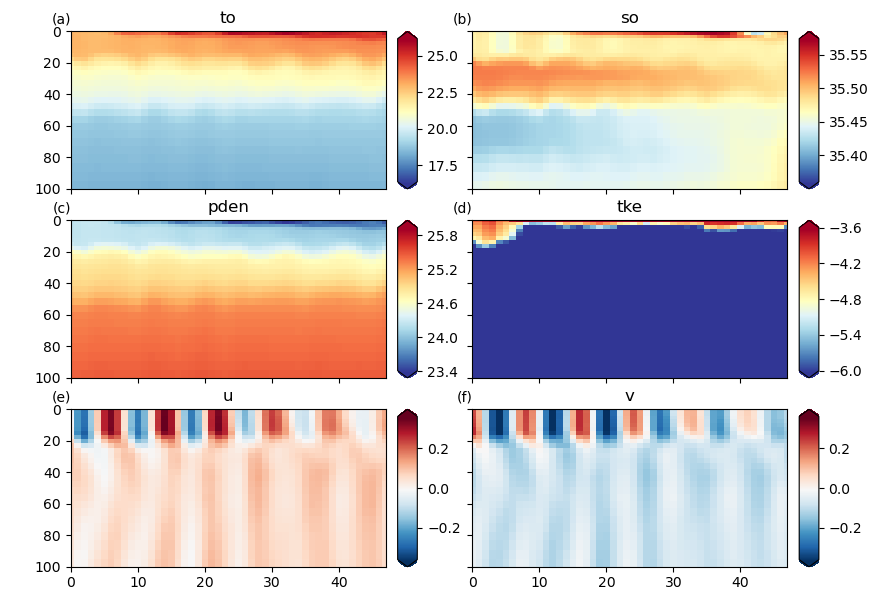

lon0 = -30, lat0 = 26


<IPython.core.display.Javascript object>


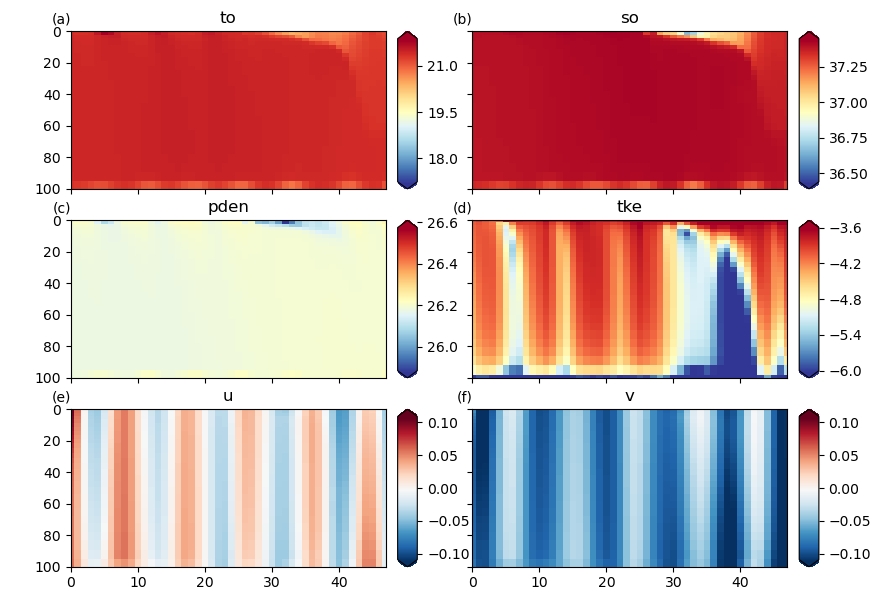

lon0 = 0, lat0 = -60


<IPython.core.display.Javascript object>


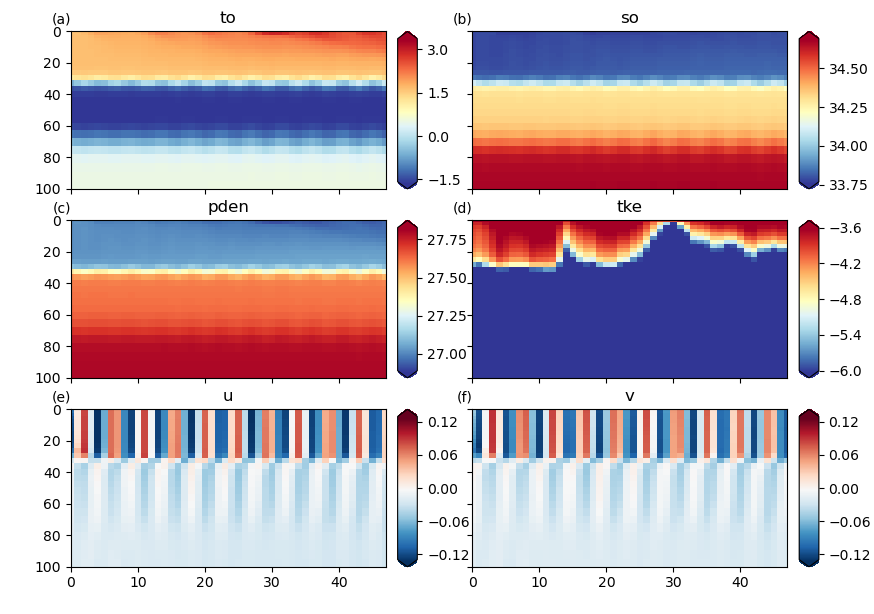

lon0 = -180, lat0 = -15


<IPython.core.display.Javascript object>


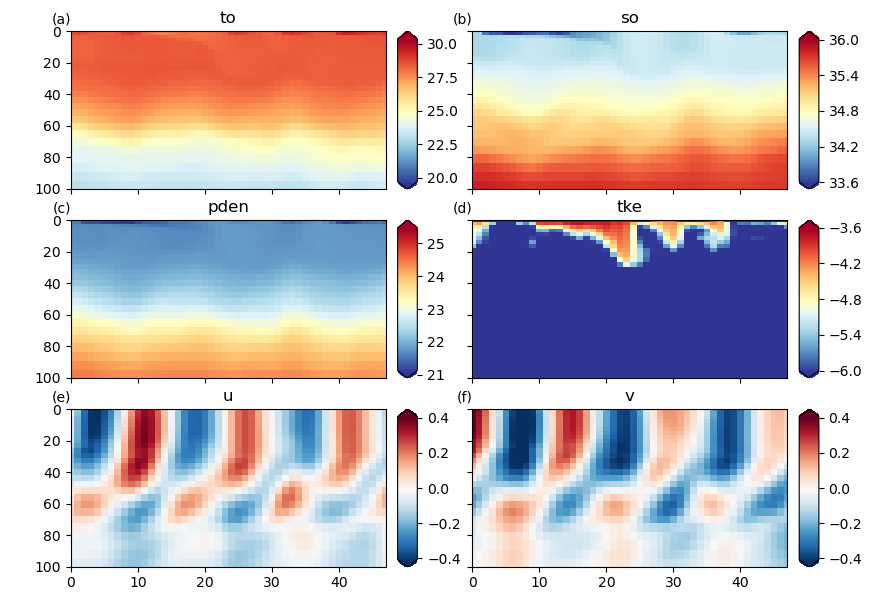

lon0 = -140, lat0 = 0


<IPython.core.display.Javascript object>


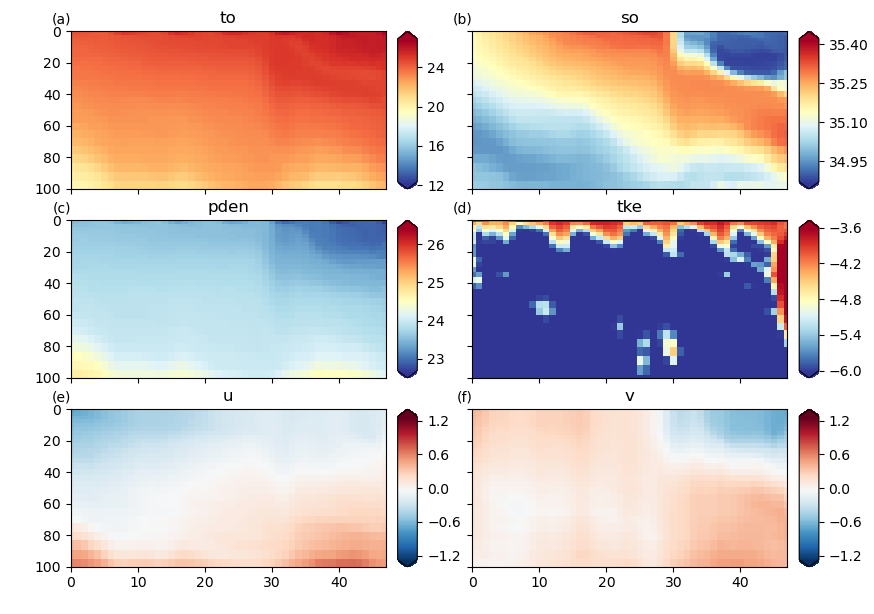

In [66]:
for icc in range(ds_sel.to.shape[2]):
    print(f'lon0 = {lon0[icc]}, lat0 = {lat0[icc]}')
    to_sel = ds_sel.to.isel(ncells=icc)
    so_sel = ds_sel.so.isel(ncells=icc)
    tke_sel = ds_sel.tke.isel(ncells=icc)
    u_sel = ds_sel.u.isel(ncells=icc)
    v_sel = ds_sel.v.isel(ncells=icc)

    pden = sw.dens(so_sel, to_sel, 0)-1000.

    hca, hcb = pyic.arrange_axes(2, 3, asp=0.5, fig_size_fac=1, 
                                 sharex=True, sharey=True, plot_cb=True,
                                )
    ii=-1
    
#     tslice = slice(0,47)
    tslice = slice(0,None)

    ii+=1; ax=hca[ii]; cax=hcb[ii]
    pyic.shade(time[tslice], depth, to_sel.isel(time=tslice).transpose(), ax=ax, cax=cax, clim=[to_sel.min(), to_sel.max()])
    ax.set_title('to')

    ii+=1; ax=hca[ii]; cax=hcb[ii]
    pyic.shade(time[tslice], depth, so_sel.isel(time=tslice).transpose(), ax=ax, cax=cax, clim=[so_sel.min(), so_sel.max()])
    ax.set_title('so')

    ii+=1; ax=hca[ii]; cax=hcb[ii]
    pyic.shade(time[tslice], depth, pden[tslice,:].transpose(), ax=ax, cax=cax, clim=[pden.min(), pden.max()])
    ax.set_title('pden')

    ii+=1; ax=hca[ii]; cax=hcb[ii]
    pyic.shade(time[tslice], depth_2, tke_sel.isel(time=tslice).data.transpose(), ax=ax, cax=cax, logplot=True, clim=[-6, -3.6])
    ax.set_title('tke')

    ii+=1; ax=hca[ii]; cax=hcb[ii]
    pyic.shade(time[tslice], depth, u_sel.isel(time=tslice).transpose(), ax=ax, cax=cax, clim=np.abs(u_sel.data).max())
    ax.set_title('u')

    ii+=1; ax=hca[ii]; cax=hcb[ii]
    pyic.shade(time[tslice], depth, v_sel.isel(time=tslice).transpose(), ax=ax, cax=cax, clim=np.abs(u_sel.data).max())
    ax.set_title('v')

    for ax in hca:
        ax.set_ylim(100,0)
        ax.set_xlim(0,47)

In [55]:
ds_2d_sel['tke4'] = tke_sel.isel(depth_2=4)

<IPython.core.display.Javascript object>


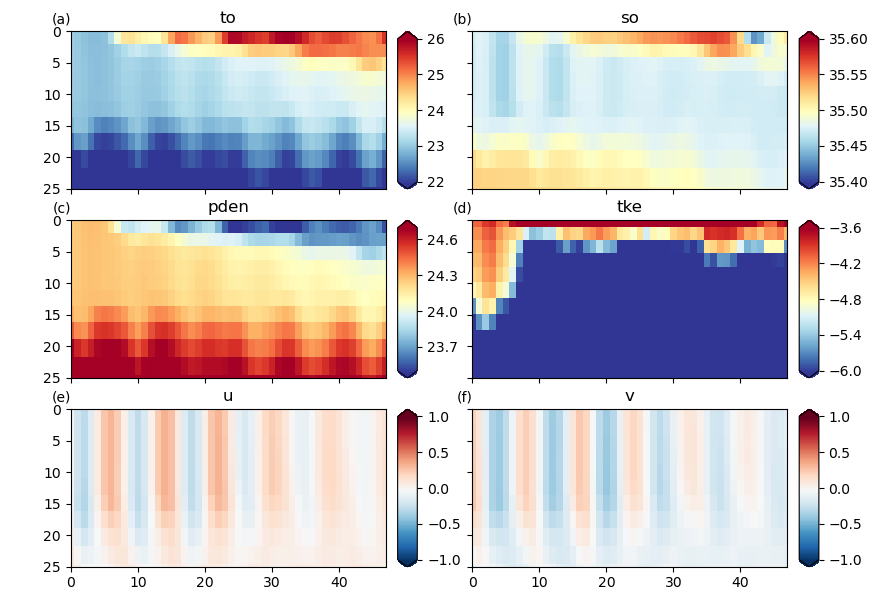

In [68]:
hca, hcb = pyic.arrange_axes(2, 3, asp=0.5, fig_size_fac=1, 
                             sharex=True, sharey=True, plot_cb=True,
                            )
ii=-1

icc=0

to_sel = ds_sel.to.isel(ncells=icc)
so_sel = ds_sel.so.isel(ncells=icc)
tke_sel = ds_sel.tke.isel(ncells=icc)
u_sel = ds_sel.u.isel(ncells=icc)
v_sel = ds_sel.v.isel(ncells=icc)

pden = sw.dens(so_sel, to_sel, 0)-1000.

ii+=1; ax=hca[ii]; cax=hcb[ii]
pyic.shade(time, depth, to_sel.transpose(), ax=ax, cax=cax, clim=[22, 26])
ax.set_title('to')

ii+=1; ax=hca[ii]; cax=hcb[ii]
pyic.shade(time, depth, so_sel.transpose(), ax=ax, cax=cax, clim=[35.4, 35.6])
ax.set_title('so')

ii+=1; ax=hca[ii]; cax=hcb[ii]
pyic.shade(time, depth, pden.transpose(), ax=ax, cax=cax, clim=[23.5, 24.7])
ax.set_title('pden')

ii+=1; ax=hca[ii]; cax=hcb[ii]
pyic.shade(time, depth_2, tke_sel.data.transpose(), ax=ax, cax=cax, logplot=True, clim=[-6, -3.6])
ax.set_title('tke')

ii+=1; ax=hca[ii]; cax=hcb[ii]
pyic.shade(time, depth, u_sel.transpose(), ax=ax, cax=cax, clim=1)
ax.set_title('u')

ii+=1; ax=hca[ii]; cax=hcb[ii]
pyic.shade(time, depth, v_sel.transpose(), ax=ax, cax=cax, clim=1)
ax.set_title('v')

for ax in hca:
    ax.set_ylim(25,0)
    ax.set_xlim(0,47)

In [64]:
icc = 4
# ds_2d_sel['tke4'] = tke_sel.isel(depth_2=4)
ds_2d_sel['SSS'] = ds_sel.so.isel(depth=0)
ds_2d_sel['SST'] = ds_sel.to.isel(depth=0)

# pvars = ['SST', 'SSS'] + pvars
print(f'lon = {lon0[icc]}, lat = {lat0[icc]}')

lon = -140, lat = 0


<IPython.core.display.Javascript object>


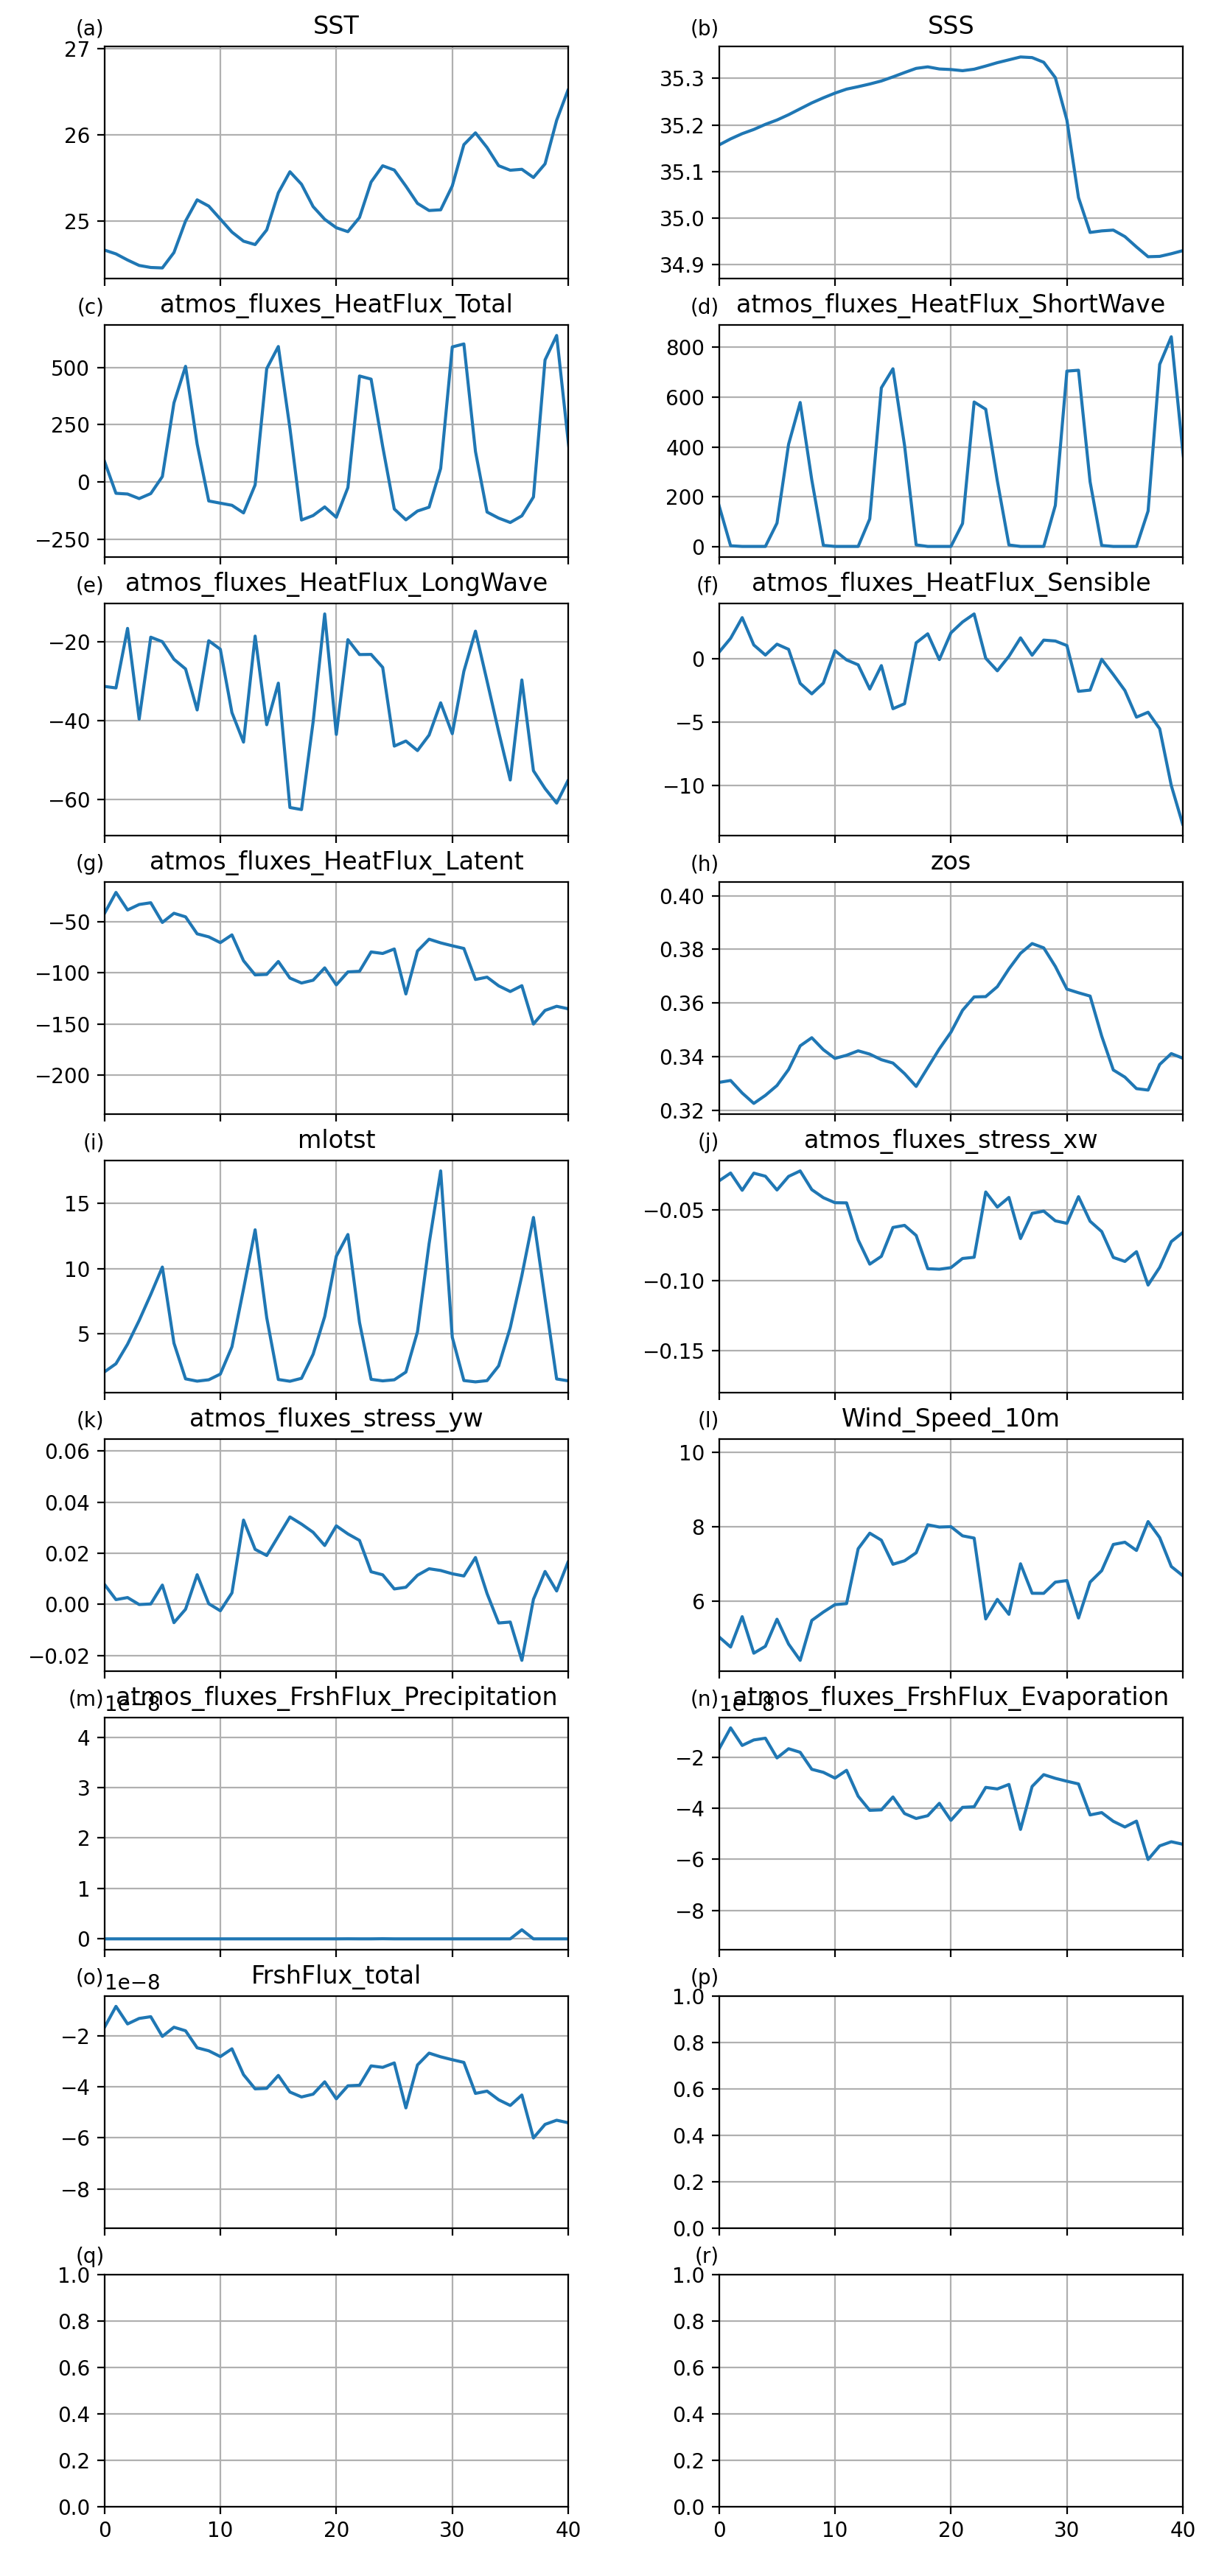

In [65]:
hca, hcb = pyic.arrange_axes(2, 9, asp=0.5, fig_size_fac=1, 
                             sharex=True, sharey=False, plot_cb=False,
                            )
ii=-1

time = np.arange(ds_2d_sel.time.size)

ylims = [
    [22.8, 26.5],
    [35.45, 35.60],
    [-100, 800],
    [0, 900],
    [-60,60],
    [-20,10],
    [-150,50],
    [0.5, 0.55],
    [0,20],
    [-0.05,0.05],
    [-0.1,0.03],
    [0, 10],
    [0,1e-7],
    [-5e-8,0],
    [-3e-8, 2e-7],
    None,
    None,
    None,
]
ylims = [None]*18

for var in pvars:
    ii+=1; ax=hca[ii]; cax=hcb[ii]
    ax.plot(time, ds_2d_sel[var].isel(ncells=icc), label=var)
    ax.set_title(var)
    if ylims[ii] is not None:
        ax.set_ylim(ylims[ii])
    
for ax in hca:
    ax.grid(True)
    ax.set_xlim(0,40)

In [74]:
ds.time[:10].data

array(['2020-01-20T03:00:00.000000000', '2020-01-20T06:00:00.000000000',
       '2020-01-20T09:00:00.000000000', '2020-01-20T12:00:00.000000000',
       '2020-01-20T15:00:00.000000000', '2020-01-20T18:00:00.000000000',
       '2020-01-20T21:00:00.000000000', '2020-01-21T00:00:00.000000000',
       '2020-01-21T03:00:00.000000000', '2020-01-21T06:00:00.000000000'],
      dtype='datetime64[ns]')

In [81]:
tstr = [0]*tke_sel.time.size
time = to_sel.time
for ll in range(len(tstr)):
    tstr[ll] = str(time[ll].data)[:16]

In [93]:
tstr[slice(3,20,4)]

['2020-01-20T12:00',
 '2020-01-21T00:00',
 '2020-01-21T12:00',
 '2020-01-22T00:00',
 '2020-01-22T12:00']

<IPython.core.display.Javascript object>


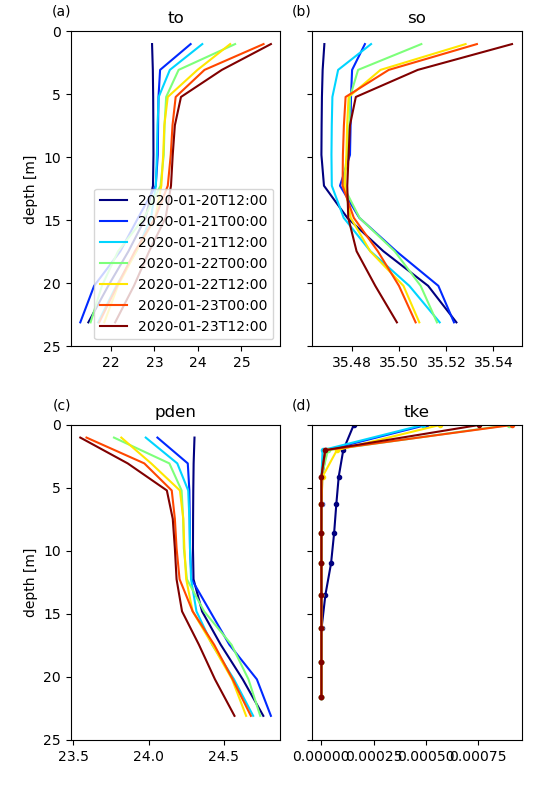

In [148]:
hca, hcb = pyic.arrange_axes(2, 2, asp=1.5, fig_size_fac=2, 
                             sharex=False, sharey=True, plot_cb=False,
                             ylabel='depth [m]',
                            )
ii=-1

nl = range(10)
nl = np.arange(3,30,4)

cols = plt.cm.jet(np.linspace(0,1,nl.size))

ii+=1; ax=hca[ii]; cax=hcb[ii]
for nn, ll in enumerate(nl):
    ax.plot(to_sel[ll,:], depth, color=cols[nn], label=tstr[ll])
ax.set_title('to')
ax.legend()
    
ii+=1; ax=hca[ii]; cax=hcb[ii]
for nn, ll in enumerate(nl):
    ax.plot(so_sel[ll,:], depth, color=cols[nn], label=tstr[ll])
ax.set_title('so')
    
ii+=1; ax=hca[ii]; cax=hcb[ii]
for nn, ll in enumerate(nl):
    ax.plot(pden[ll,:]-1000., depth, color=cols[nn], label=tstr[ll])
ax.set_title('pden')
    
ii+=1; ax=hca[ii]; cax=hcb[ii]
for nn, ll in enumerate(nl):
    ax.plot(tke_sel[ll,:], depth_2, color=cols[nn], label=tstr[ll], marker=".")
ax.set_title('tke')
    
for ax in hca:
    ax.set_ylim(25,0)